In [1]:
import numpy as np
import matplotlib.pyplot as plt
from network_analysis import network_tools as nt
# make figures crisp
%config InlineBackend.figure_format = 'retina'

# General parameters
We first set general parameters of our network.

Namely, we define the characteristic impedance $Z_0$ and the speed of light in the transmission lines $\nu_p$ (a.k.a. phase velocity).

In [2]:
# Parameters
c = 3e8                     # speed of light in vaccum
eps_r = 11.45               # relative permeability of our substrate
vp = c/np.sqrt((1+eps_r)/2) # speed of light in the transmission line
Z0 = 50                     # characteristic impedance

# Setup microwave network
We can setup a microwave network using the "Network" instance of the network_tools library.

Elements such can be added to the network using the network.add_* methods. These include:
- capacitors (series or parallel)
- inductors (series or parallel)
- resistors (series or parallel)
- transmission lines (series or parallel)
- attenuators
- amplifiers
- capacitively coupled resonators
- inductively coupled resonators

In the following, we setup an example network and used the "draw_network" method to visualize it.
The scattering parameters of the network can be obtained using the "get_S_parameters" method.

## Standard components

### Low-pass filter

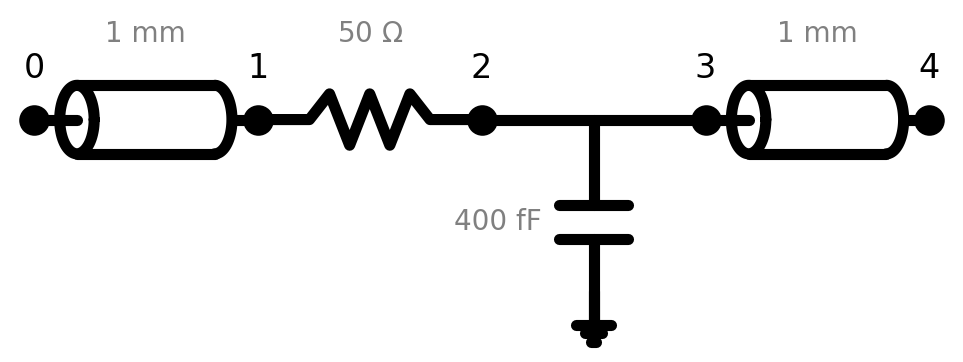

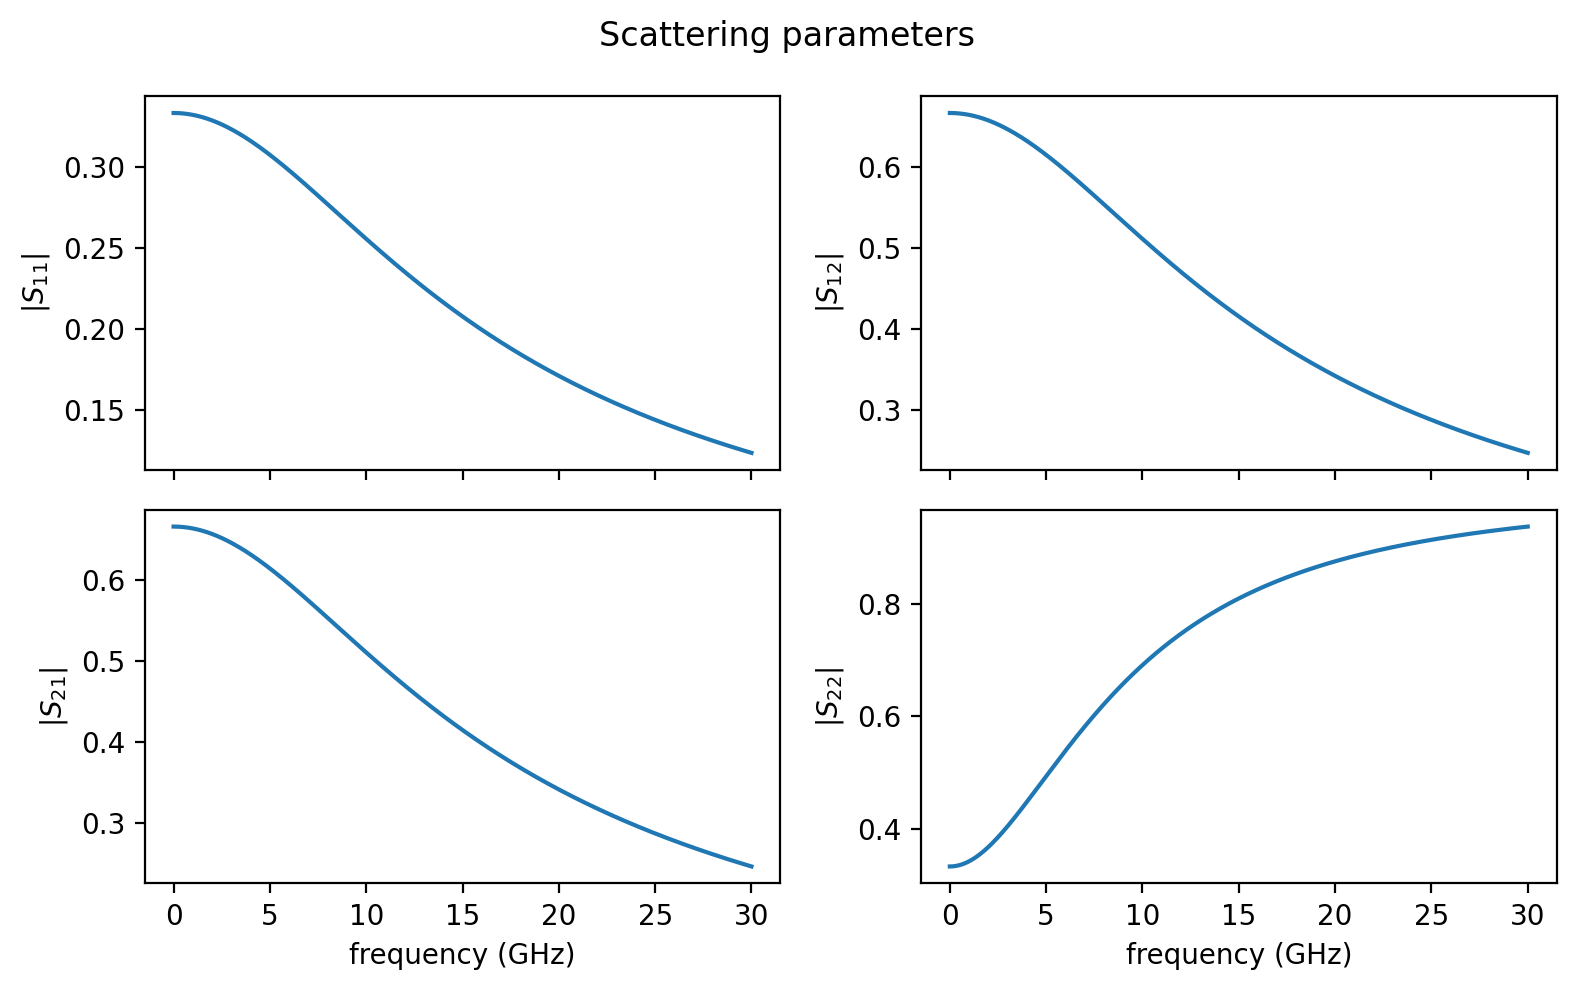

In [3]:
# setup network instance
network = nt.Network(Zgen=Z0)

# add elements
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.add_resistor(R=50, element_type='series')
network.add_capacitance(C=400e-15, element_type='parallel')
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)

# draw network schematic
network.draw_network()

# plot s21 of network
s11, s12, s21, s22 = network.get_S_parameters(frequency=np.linspace(1,30e9,1000), plot=True)

### RLC resonator

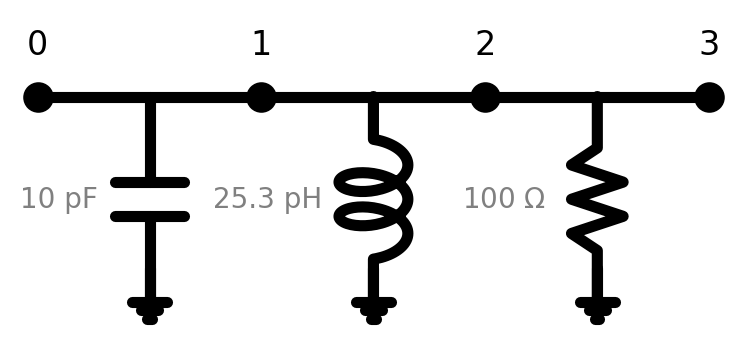

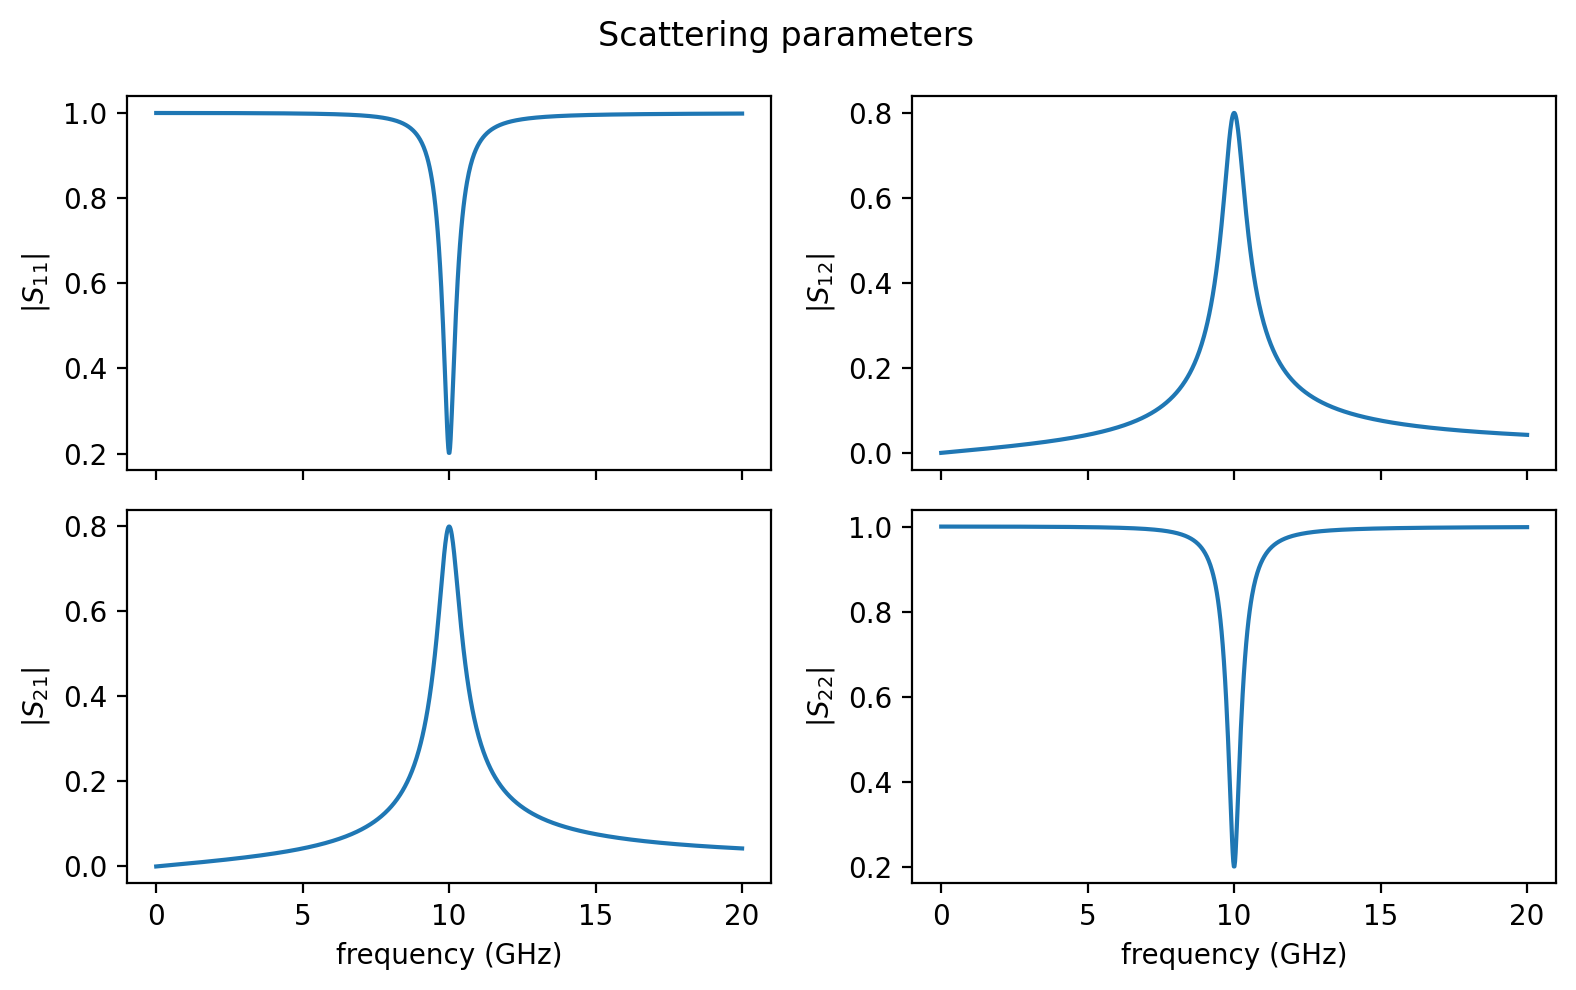

In [4]:
# compute element requirements for resonance frequency
resonance_frequency = 10e9
C = 10e-12
L = 1/(C* (2*np.pi*resonance_frequency)**2 )

# setup network instance
network = nt.Network(Zgen=Z0)
network.add_capacitance(C=C, element_type='parallel')
network.add_inductance(L=L, element_type='parallel')
network.add_resistor(R=1e2, element_type='parallel')
network.draw_network()
s11, s12, s21, s22 = network.get_S_parameters(frequency=np.linspace(1,20e9,1000), plot=True)

### Capacitively coupled resonator

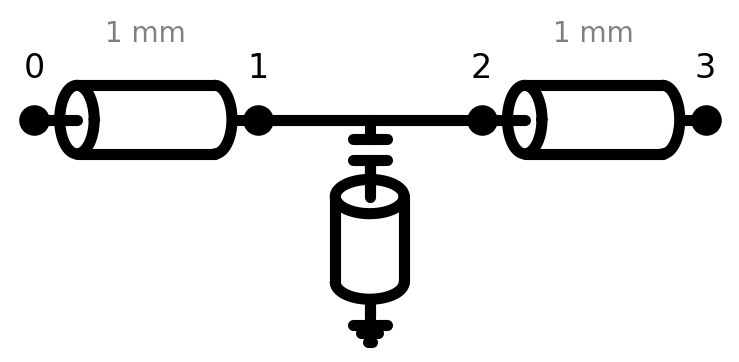

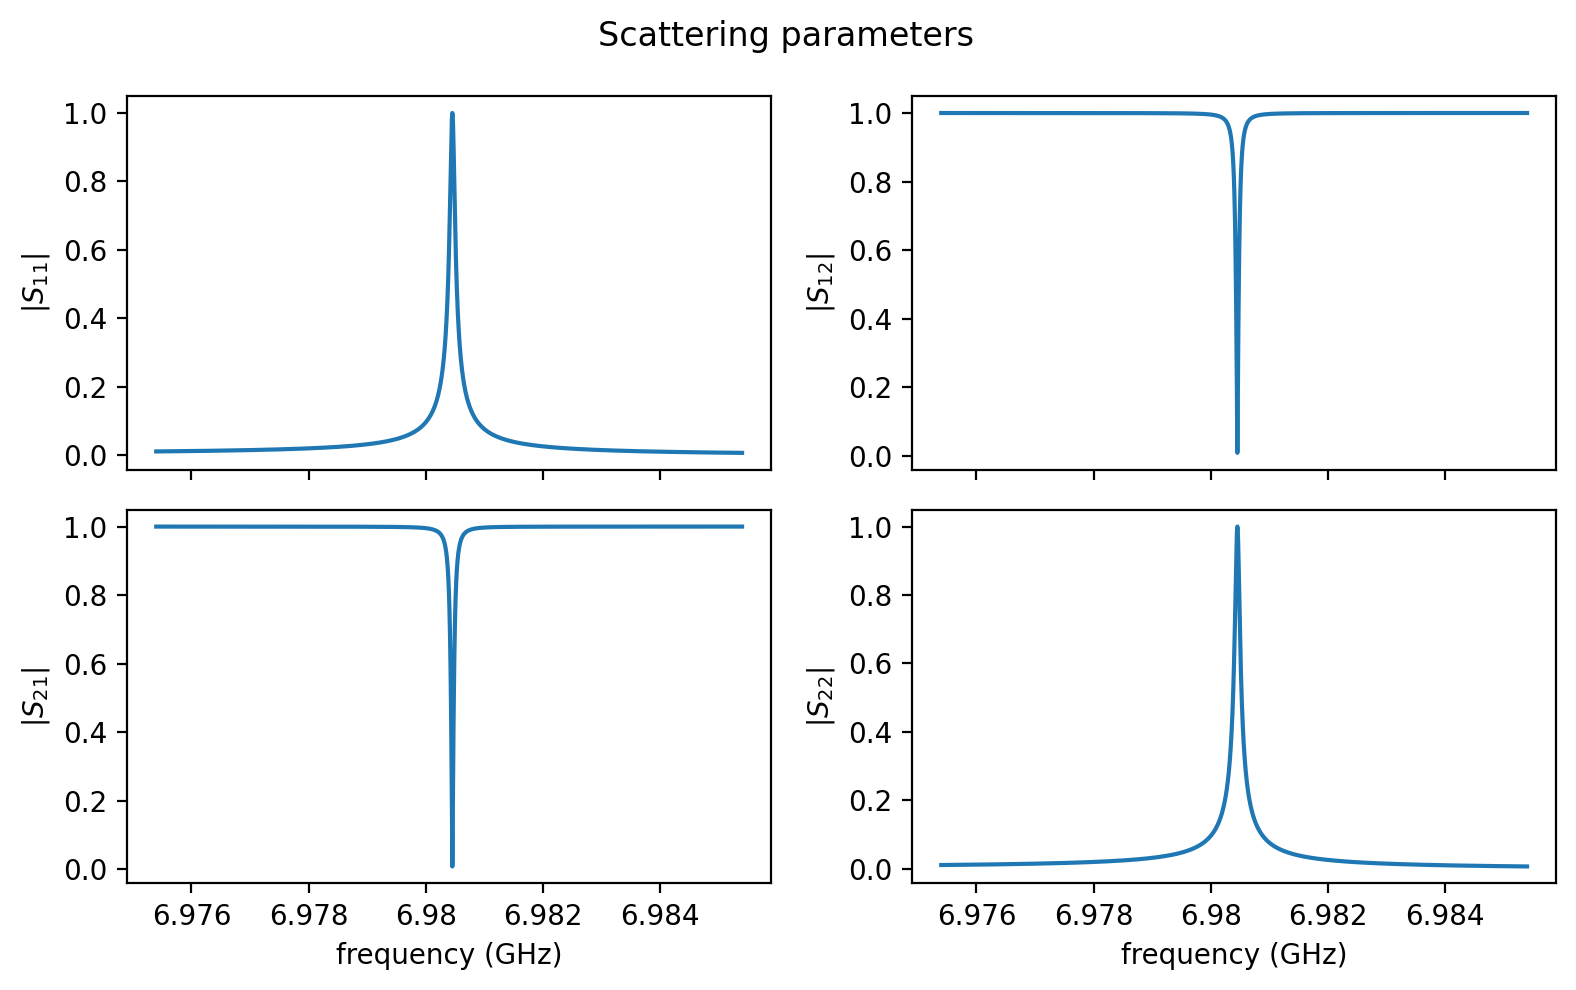

In [131]:
# compute length required for lambda.4 resonator
f0 = 7e9
resonator_length = vp/4/f0
# correction to resonator frequency from capacitor
C_res = 2e-15 # capacitive coupling
f_corr = f0 - 4*Z0*C_res*f0**2

# setup network instance
network = nt.Network(Zgen=Z0)
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.add_capacitively_coupled_hanger(length=resonator_length, Z0=Z0, phase_velocity=vp, Z_termination=0, C_coupling=C_res)
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.draw_network()

s11, s12, s21, s22 = network.get_S_parameters(frequency=np.linspace(-5e6, 5e6,10000)+f_corr , plot=True)

## Amplifiers and attenuators

Composite components such as attenuators and amplifiers are also available. These are implemented as resistor $\pi$-networks.

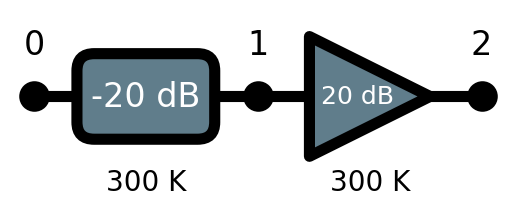

In [6]:
# setup network instance
network = nt.Network(Zgen=Z0)
network.add_attenuator(attn_dB=20, Z0=50, temperature_K=300)
network.add_amplifier(gain_dB=20, Z0=50, temperature_K=300)
network.draw_network()

## Custom components

Some custom components can be added to this library using the standard measurement file format `.s2p`.
Such files can be obtained from manufacturers datasheets (eg. https://www.minicircuits.com/WebStore/dashboard.html?model=SLP-50%2B&srsltid=AfmBOoo_zzyOJ2QB_0s1uFt5a_lvFSy9ty_q_vqD4MIbur68n0FQQfzo). 
Alternatively, these files can be obtained from VNA measurements of the full scattering parameters.

See `.\circuit_components\` directory for available components.

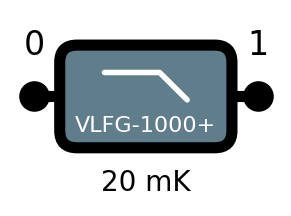

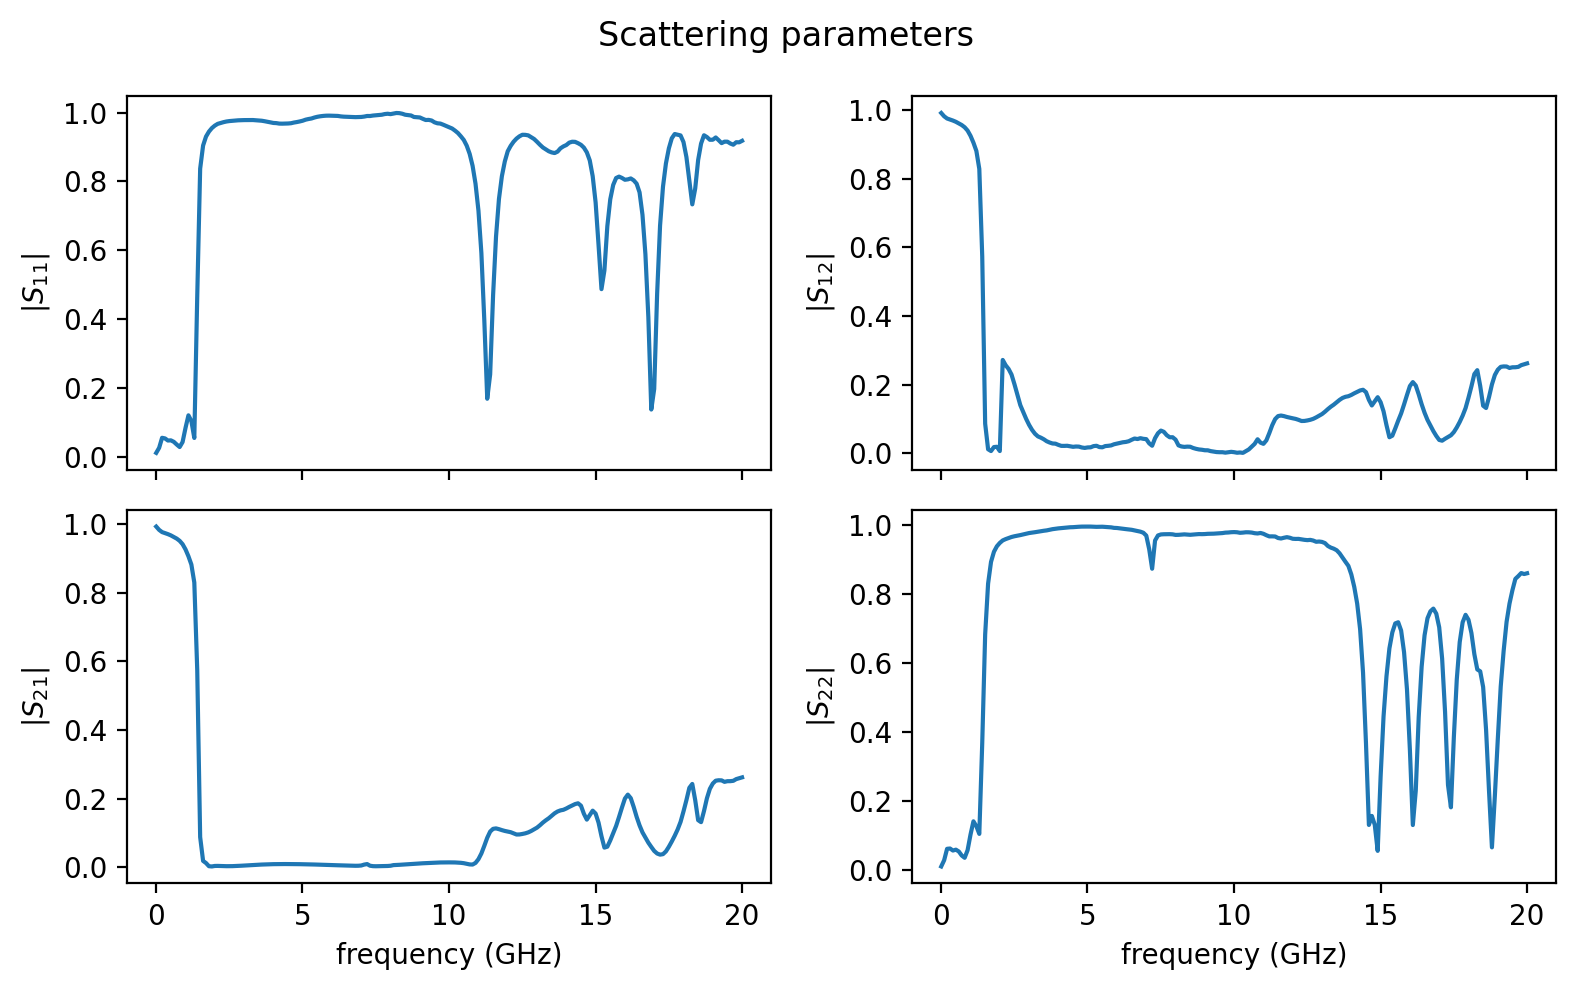

In [12]:
# Example: Mini circuits' VLFX-1000+ low pass filter
network = nt.Network(Zgen=Z0)
network.add_custom_component('VLFG-1000+', temperature_K=20e-3)
network.draw_network()
s11, s12, s21, s22 = network.get_S_parameters(frequency=np.linspace(10e6, 20e9, 201) , plot=True)

# Get properties of network

After a network instance has been setup, we can extract the following properties from it:
- Scattering matrix, $S_{ij}$
- Impedance matrix, $Z_{ij}$
- Voltage and current phasors
- Signal response
- Power spectral density

## Scattering matrix

An example of scattering parameters for a input capacitance transmission line. The scattering matrix, $S_{ij}$, of the network is calculated using the `get_S_parameters` method.

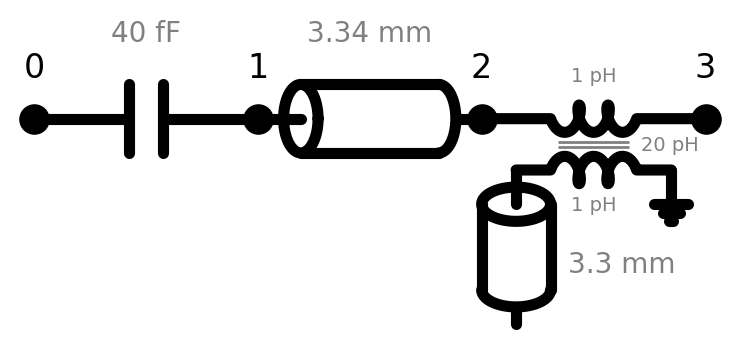

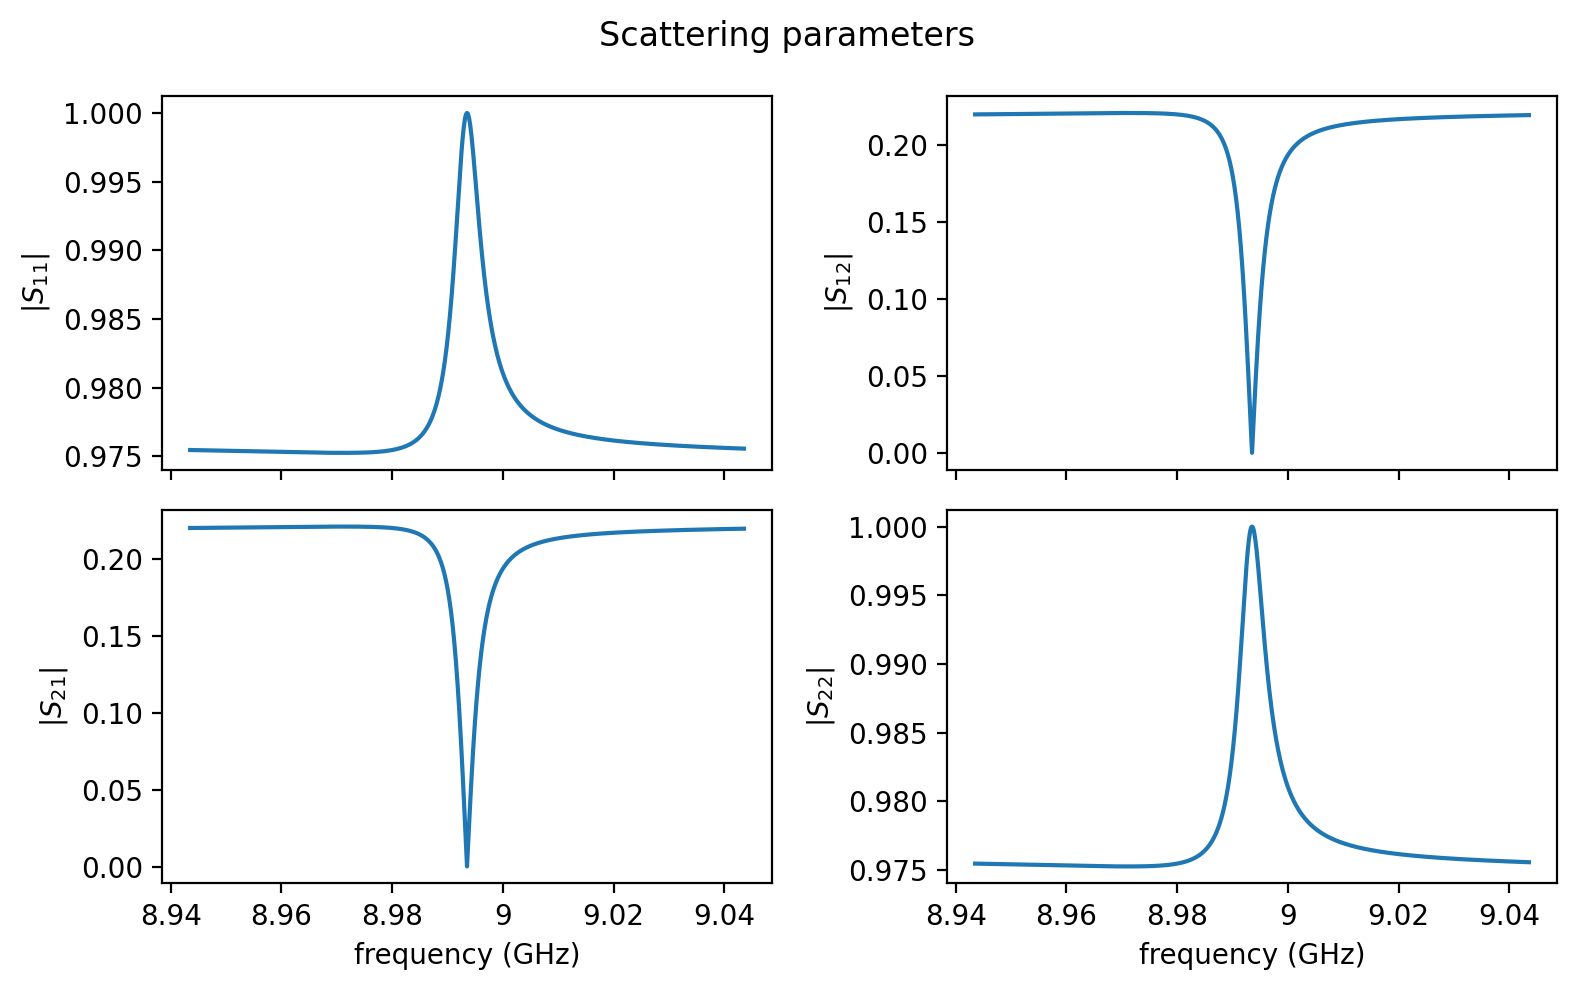

In [210]:
# Setup network
network = nt.Network(Zgen=Z0)

# length of resonator at 9 GHz
f_res = 9e9 
l_res = vp/(4*f_res)
# correction to resonator frequency from mutual inductance
M_ind = 2e-11  # mutal inductance between lines
L_char = 1e-12 # inductance of lines
f_corr = f_res - 4*L_char/Z0*f_res**2

network.add_capacitance(C = 40e-15, element_type='series')
network.add_transmission_line(length=l_res, Z0=Z0, phase_velocity=vp)
network.add_inductively_coupled_hanger(length=l_res, Z0=Z0, phase_velocity=vp, L_line=L_char, L_hanger=L_char, M_inductance=M_ind,
                                       Z_termination=1e10) # open ended (very high impedance)
network.draw_network()

# frequency axis
freq_axis = f_corr + np.linspace(-50e6, +50e6, 1001)

# scattering parameters
S_pars = network.get_S_parameters(frequency=freq_axis, plot=True)

## Impedance matrix

The impedance matrix, $z_{ij}$, as well as the loaded input and output impedances, $Z_\mathrm{in}$ and $Z_\mathrm{out}$, of the network are calculated using the `get_Z_parameters` method.

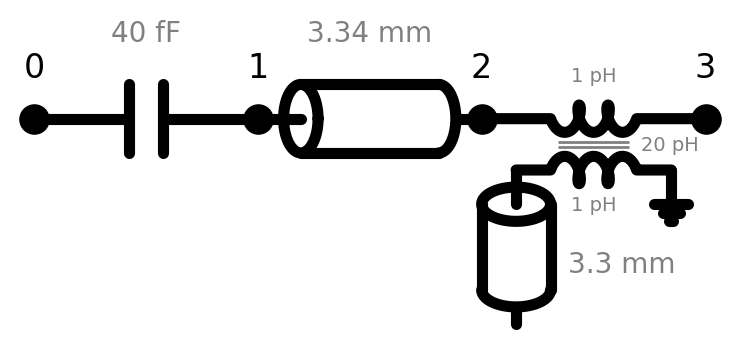

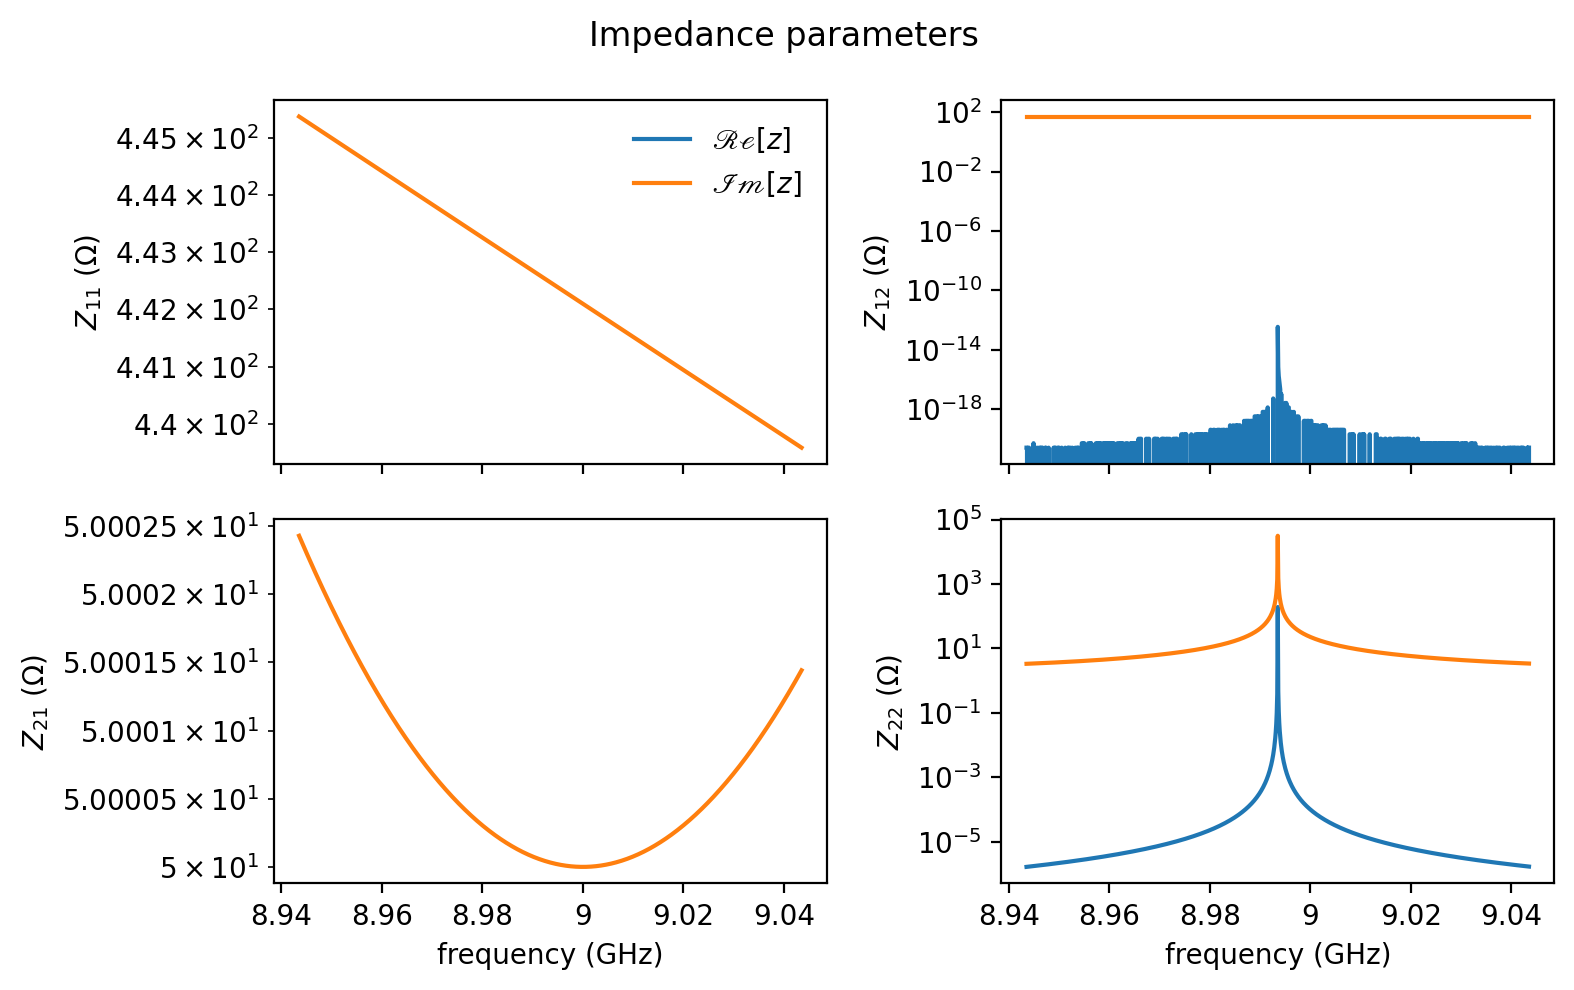

In [211]:
network.draw_network()

# frequency axis
freq_axis = f_corr + np.linspace(-50e6, +50e6, 1001)

# impedance parameters
z11, z12, z21, z22, zin, zout = network.get_Z_parameters(frequency=freq_axis, Z_load=Z0, plot=True)

## Node voltage and current

## Signal response

## Thermal noise

Some components may have a temperature associated with them. This can be used to estimate noise properties at certain nodes of the network, namely, the thermal noise power spectral density and other quantities derived from it.

Here is an example of this analysis in the context of filtering for a flux line.

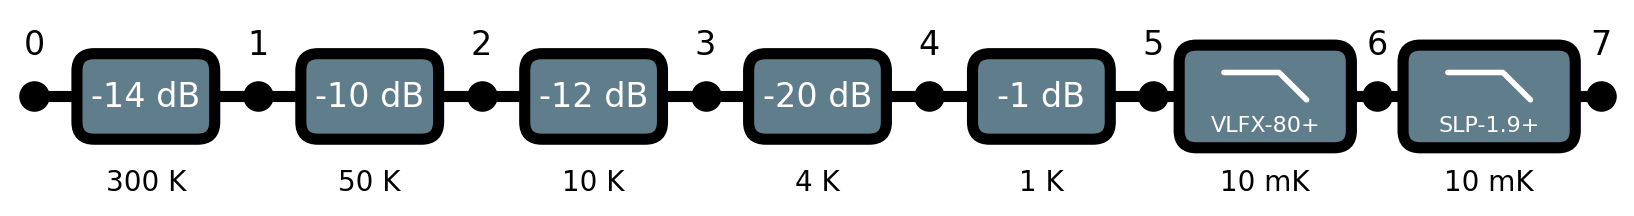

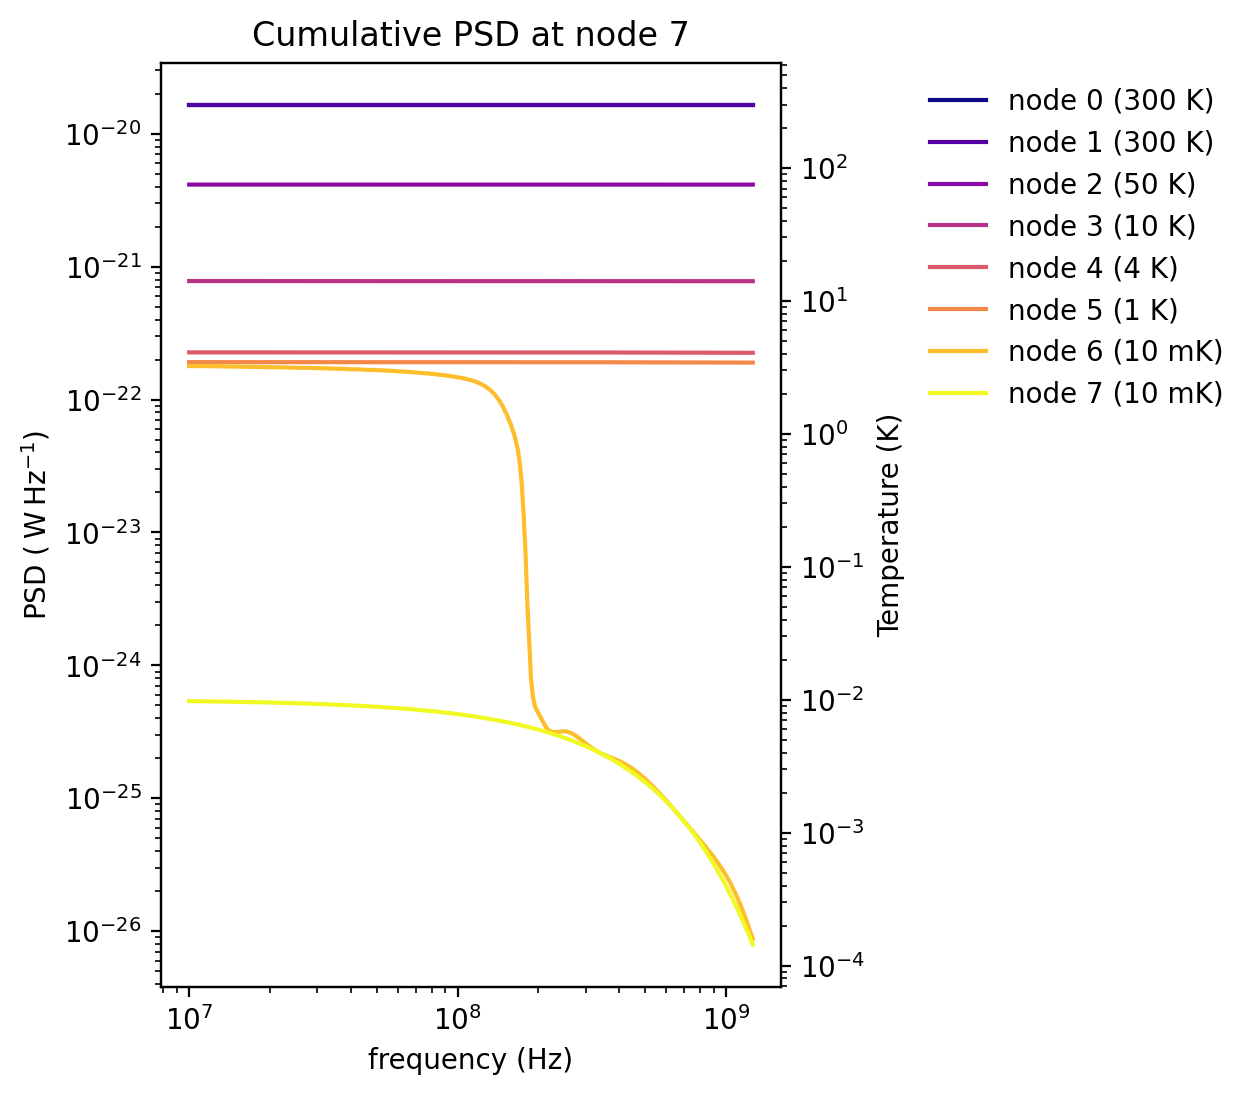

In [11]:
# Setup network
network = nt.Network(Zgen=Z0)
# flux line filtering
network.add_attenuator(attn_dB=14.4, temperature_K=300, Z0=Z0)   # RT cables
network.add_attenuator(attn_dB=10, temperature_K=50, Z0=Z0)      # 50K 
network.add_attenuator(attn_dB=12, temperature_K=10, Z0=Z0)      # cryo cables
network.add_attenuator(attn_dB=20, temperature_K=4, Z0=Z0)       # 4K 
network.add_attenuator(attn_dB=1, temperature_K=1, Z0=Z0)        # still
network.add_custom_component('VLFX-80+', temperature_K=10e-3)
network.add_custom_component('SLP-1.9+', temperature_K=10e-3)
network.draw_network()

# frequency axis
frequency = np.logspace(7, 9.1, 301)

# Plot simulated PSD
PSD = network.get_psd_at_node(frequency=frequency, initial_node_temp=300, plot=True)